In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sklearn as skl
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

In [40]:
train=pd.read_csv("../train.csv")
test=pd.read_csv("../test.csv")
sample=pd.read_csv("../sample.csv",header=None)
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
0,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
1,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
3,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
4,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [41]:
train["payday"] = train["payday"].fillna(0)
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x == "--" else float(x))
train["event"] = train["event"].fillna("なし")
train["remarks"] = train["remarks"].fillna("なし")
train["month"] = train["datetime"].apply(lambda x : int(x.split("-")[1]))

test["payday"] = test["payday"].fillna(0)
test["precipitation"] = test["precipitation"].apply(lambda x : -1 if x == "--" else float(x))
test["event"] = test["event"].fillna("なし")
test["remarks"] = test["remarks"].fillna("なし")
test["month"] = test["datetime"].apply(lambda x : int(x.split("-")[1]))

In [42]:
train.index = pd.to_datetime(train["datetime"])
train=train["2014-05-01":]
train["fun"]=train["remarks"].apply(lambda x:1 if x=="お楽しみメニュー" else 0)
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
train["hbg"] = train["name"].apply(lambda x : 1 if x.find("ハンバーグ")>=0 else 0)

test.index = pd.to_datetime(test["datetime"])
test["fun"]=test["remarks"].apply(lambda x:1 if x=="お楽しみメニュー" else 0)
test["curry"] = test["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
test["hbg"] = test["name"].apply(lambda x : 1 if x.find("ハンバーグ")>=0 else 0)

In [43]:
avg=train["kcal"].mean()
train["kcal"]=train["kcal"].fillna(avg)
test["kcal"]=test["kcal"].fillna(avg)

In [44]:
train["kcal_bining"]=pd.cut(train["kcal"],[310,370,390,410,430,470])
#print(train["kcal_bining"].value_counts())
train["temperature_bining"]=pd.cut(train["temperature"],[0,5,10,15,20,25,30,35])
#print(train["temperature_bining"].value_counts())

train=train[train["weather"]!="雷電"]
train=train[train["weather"]!="雪"]

test["kcal_bining"]=pd.cut(test["kcal"],[310,370,390,410,430,470])
#print(test["kcal_bining"].value_counts())
test["temperature_bining"]=pd.cut(test["temperature"],[0,5,10,15,20,25,30,35])
#print(test["temperature_bining"].value_counts())

In [45]:
trainX=train[["fun","month","temperature_bining","curry","hbg"]]
testX=test[["fun","month","temperature_bining","curry","hbg"]]
trainX=pd.get_dummies(trainX)
testX=pd.get_dummies(testX)
print(trainX.shape)
print(testX.shape)

(100, 11)
(40, 11)


In [46]:
y=train["y"]

In [48]:
#clf1=DTR()
#parameters={"max_depth":list(range(2,21)), "min_samples_leaf":[10,20,30,40,50,60,70,100]}
clf1=RFR()
parameters={"max_depth":list(range(2,16)), 
            "min_samples_leaf":[5,10,20,50,100,500],
            "n_estimators":[60,80,100,120],
            "max_features":[1,None,"auto"]}

In [49]:
gcv=GridSearchCV(clf1, parameters, cv=5, scoring="neg_mean_squared_error",n_jobs=-1,return_train_score=True)
gcv.fit(trainX,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'min_samples_leaf': [5, 10, 20, 50, 100, 500], 'n_estimators': [60, 80, 100, 120], 'max_features': [1, None, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [50]:
print(gcv.best_params_)
print(gcv.best_score_)

{'max_depth': 4, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 80}
-168.2629042924019


In [51]:
train_score=gcv.cv_results_["mean_train_score"]
test_score=gcv.cv_results_["mean_test_score"]

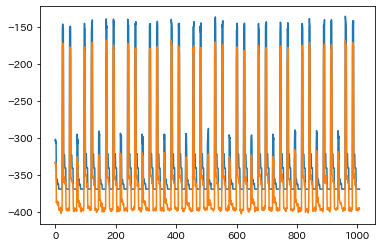

In [52]:
plt.plot(train_score)
plt.plot(test_score)

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month,fun,curry,hbg,kcal_bining,temperature_bining,pred,res
datetime,,,,,,,,,,,,,,,,,,,,
2014-05-21,2014-5-21,104,水,1,チーズハンバーグ,430.000000,なし,なし,0.0,雨,6.0,17.4,5,0,0,1,"(410, 430]","(15, 20]",74.804151,-29.195849
2014-08-08,2014-8-8,129,金,0,チキンカレー,410.296703,お楽しみメニュー,なし,1.0,曇,-1.0,31.1,8,1,1,0,"(410, 430]","(30, 35]",102.059510,-26.940490
2014-05-16,2014-5-16,126,金,0,ポークカレー,410.296703,お楽しみメニュー,ママの会,0.0,快晴,-1.0,23.8,5,1,1,0,"(410, 430]","(20, 25]",103.353014,-22.646986
2014-07-07,2014-7-7,82,月,1,和風ハンバーグ,354.000000,なし,なし,0.0,雨,0.5,24.0,7,0,0,1,"(310, 370]","(20, 25]",60.532041,-21.467959
2014-07-11,2014-7-11,124,金,0,ポークカレー,410.296703,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.9,7,1,1,0,"(410, 430]","(30, 35]",102.663107,-21.336893
2014-06-06,2014-6-6,93,金,0,手作りロースカツ,430.000000,なし,なし,0.0,雨,6.5,19.9,6,0,0,0,"(410, 430]","(15, 20]",71.843181,-21.156819
2014-08-04,2014-8-4,75,月,1,ハンバーグ（デミきのこバター）,410.000000,なし,なし,0.0,曇,-1.0,32.7,8,0,0,1,"(390, 410]","(30, 35]",56.456856,-18.543144
2014-06-13,2014-6-13,121,金,0,キーマカレー,410.296703,お楽しみメニュー,なし,0.0,晴れ,-1.0,29.5,6,1,1,0,"(410, 430]","(25, 30]",102.706365,-18.293635
2014-09-02,2014-9-2,68,火,1,名古屋味噌カツ,440.000000,手作りの味,なし,0.0,晴れ,-1.0,29.1,9,0,0,0,"(430, 470]","(25, 30]",51.265944,-16.734056


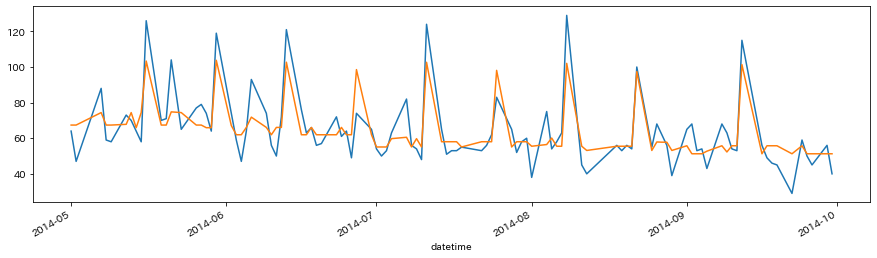

In [53]:
train["pred"]=gcv.predict(trainX)
train["res"]=train["pred"]-train["y"]
train["y"].plot(figsize=(15,4))
train["pred"].plot(figsize=(15,4))
train.sort_values(by="res")

In [55]:
pred=gcv.predict(testX)
sample[1]=pred
sample.to_csv("submit5_RFR.csv",index=None,header=None)